### Feature Creation for Spatial Regression Analysis

1. Load in datasets to analyse a set of built environment, socioeconomic, and risk perception features
2. Calculate features and observe distributions against the SRM "slope"
3. Standardise features to align to a similar numerical range
4. Log transform features as needed

In [1]:
#pip install xlrd

In [2]:
# Import modules

import pandas as pd
import datetime
from datetime import datetime
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
import math
from math import sqrt
import numpy as np
import random


random.seed(42)
sns.set_theme(style="whitegrid")
pd.options.display.float_format = '{:,.2f}'.format
#sns.set(font_scale=2)

#### Read in Datasets to perform Spatial Regression Analysis

1. Jobs: http://www.nomisweb.co.uk/census/2011/dc6604ew
2. IMD by MSOA: https://research.mysociety.org/sites/imd2019/about/
3. MSOA Area Size: https://data.gov.uk/dataset/aceaceab-797b-4fde-a4e6-ec6002fb7f08/standard-area-measurements-2011-for-2011-census-areas-in-england-and-wales
4. Vehicle Ownership: https://data.london.gov.uk/dataset/msoa-atlas
5. Income: https://data.london.gov.uk/dataset/ons-model-based-income-estimates--msoa
6. Covid Deaths by MSOA: https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/deathsduetocovid19bylocalareaanddeprivation
7. CLT MSOAs: https://data.london.gov.uk/dataset/cycling-infrastructure-database
8. Road MSOAs: https://osdatahub.os.uk/downloads/open/OpenRoads?_ga=2.106254016.2142301253.1626191853-1483327713.1626191853
9. Points of Interest (POI) MSOAs: https://digimap.edina.ac.uk/webhelp/os/data_information/os_products/points_of_interest.htm

In [3]:
# Read in csv data

pt_msoaest = pd.read_csv('../output_data/pt_msoaest.csv')
jobs = pd.read_csv('../data/jobs_msoa_2011_Census.csv')
imd_msoa = pd.read_csv('../data/imd2019_msoa_level_data.csv')


msoa_area = pd.read_csv('../data/SAM_MSOA/SAM_MSOA_DEC_2011_EW.csv')
vehicle_owner = pd.read_csv('../data/census_carperhousehold.csv')
income = pd.read_excel('../data/ons-model-based-income-estimates-msoa-1.xls', sheet_name = '2015-16 (annual income)')
coviddeaths = pd.read_csv('../data/coviddeaths_MarNov.csv')

# Shape Files
slope_msoa_jun = gpd.read_file('../output_data/slope_msoa_jun.shp')
boroughs = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
msoas = gpd.read_file('../data/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
clt_msoas = gpd.read_file('../data/clt_msoas.shp')
road_msoas = gpd.read_file('../data/road_msoas.shp')
poi_msoas_lon = gpd.read_file('../data/poi_msoas_greaterlondon.shp')
                         
boroughs = boroughs.to_crs('epsg:27700')
msoas = msoas.to_crs('epsg:27700')
clt_msoas = clt_msoas.to_crs('epsg:27700')

In [4]:
# Export poi_msoas, joining to get London MSOAs takes a lot of time, so we will do this once.
#poi = gpd.read_file('POI_GS/poi_4125257/poi_4125257.gpkg')
#df = poi
#df = gpd.sjoin(df, msoas, op = 'within')
#df.to_file('poi_msoas_greaterlondon.shp')

In [5]:
# Export road_msoas, joining to get London MSOAs takes a lot of time, so we will do this once.

#df = road
#df = gpd.sjoin(df, msoas, op = 'within')
#df.head()
#road_msoas = df

#road_msoas.to_file('road_msoas.shp')

#### Feature Creation

In [6]:
#slope_msoa = gpd.read_file('output_data/slope_msoa.shp')
#slope_msoa_jun.info()

In [7]:
# Reduce jobs data to relevant columns, estimate percentage of homeworking of total working population
# Jobs Data: 
# Homeworking % Data:

df = jobs

df = df.rename({'geography code':'msoa_code',
'geography': 'msoa_name',                
'Occupation: All categories: Occupation; Industry: All categories: Industry; measures: Value': 'all_occupations',
'Occupation: 1. Managers, directors and senior officials; Industry: All categories: Industry; measures: Value':'managers',
'Occupation: 2. Professional occupations; Industry: All categories: Industry; measures: Value':'professional_occupations',
'Occupation: 3. Associate professional and technical occupations; Industry: All categories: Industry; measures: Value':'associate_professional',
'Occupation: 4. Administrative and secretarial occupations; Industry: All categories: Industry; measures: Value':'administrative',
'Occupation: 5. Skilled trades occupations; Industry: All categories: Industry; measures: Value':'skilled_trade',
'Occupation: 6. Caring, leisure and other service occupations; Industry: All categories: Industry; measures: Value':'caring',
'Occupation: 7. Sales and customer service occupations; Industry: All categories: Industry; measures: Value':'sales',
'Occupation: 8. Process, plant and machine operatives; Industry: All categories: Industry; measures: Value':'plant_machine',
'Occupation: 9. Elementary occupations; Industry: All categories: Industry; measures: Value':'elementary_occupations'}, axis=1)

df = df[['msoa_code',
         'msoa_name',
         'managers',
         'professional_occupations',
         'associate_professional',
         'administrative',
         'skilled_trade',
         'caring',
         'sales',
         'plant_machine',
         'elementary_occupations',
         'all_occupations']]

# The numbers below are hard-coded based on homeworking data from a survey
# https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/employmentandemployeetypes/datasets/homeworking
df['managers_hw'] = df['managers']*.67349
df['professional_occupations_hw'] = df['professional_occupations']*.69582
df['associate_professional_hw'] = df['associate_professional']*.63719
df['administrative_hw'] = df['administrative']*.57242
df['skilled_trade_hw'] = df['skilled_trade']*.18519
df['caring_hw'] = df['caring']*.14894
df['sales_hw'] = df['sales']*.15914
df['plant_machine_hw'] = df['plant_machine']*.05439
df['elementary_occupations_hw'] = df['elementary_occupations']*0

df['all_occupations_hw'] = df['managers_hw']+df['professional_occupations_hw']+df['associate_professional_hw']+df['administrative_hw']+df['skilled_trade_hw']+df['caring_hw']+df['sales_hw']+df['plant_machine_hw']+df['elementary_occupations_hw']
df['hw_pct'] = df['all_occupations_hw']/df['all_occupations']
df_avg = (df['all_occupations_hw'].agg('sum'))/(df['all_occupations'].agg('sum'))
#df['hw_pct_std'] = df['hw_pct']/df_avg
df = df[['msoa_code', 'msoa_name', 'hw_pct']]


jobs_hw = df
#jobs_hw.head()

In [8]:
# Covid Deaths by MSOA, monthly. This will capture data till end of September versus mid-September. 

#coviddeaths['coviddeaths'] = coviddeaths['April'] + coviddeaths['May'] + coviddeaths['June'] + coviddeaths['July'] + coviddeaths['August'] + coviddeaths['September']
coviddeaths['coviddeaths'] = coviddeaths['June'] + coviddeaths['July'] + coviddeaths['August'] + coviddeaths['September']
coviddeaths = coviddeaths.merge(msoas, how = 'left', left_on ='MSOA code', right_on = 'MSOA11CD')
coviddeaths['coviddeaths_den'] = coviddeaths['coviddeaths']/coviddeaths['POPDEN']

coviddeaths = coviddeaths[['MSOA code','coviddeaths','coviddeaths_den']]


#coviddeaths.head()

In [9]:
# Cycling data, load in MSOAs by Hectare to normalise the metres of cycle paths versus area of MSOA. 

clt_msoas_dropgeo = clt_msoas[['msoa11cd', 'length']]
clt_msoas_dropgeo = clt_msoas_dropgeo.merge(msoa_area, left_on = 'msoa11cd', right_on = 'MSOA11CD')
clt_msoas_dropgeo['cyclelength_perhect'] = clt_msoas_dropgeo['length']/clt_msoas_dropgeo['AREAEHECT']

#clt_msoas_dropgeo.head()

In [10]:
# Calculate road length per hectacre

df = road_msoas
df = df.groupby(['MSOA11CD', 'MSOA11NM', ])['length'].agg('sum').reset_index()
df = df.merge(msoa_area, left_on = ['MSOA11NM','MSOA11CD'], right_on = ['MSOA11NM','MSOA11CD'])
df['roadlength_perhect'] = df['length']/df['AREAEHECT']
road_length = df

In [11]:
# Count the following locations
# 1. category name = Bus Transport, classname = Bus Stops
# 2. category name = 'Public Transport, Stations and Infrastructure', may be collinear with number_tubestations
# 3. category name = Primary, Secondary and Tertiary Education
# 4. category name = 'Recreational'

df = poi_msoas_lon
df_poi = poi_msoas_lon[['MSOA11CD']].drop_duplicates()

df_education = df[df['categoryna']=='Primary, Secondary and Tertiary Education'].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
df_education = df_education.rename({'categoryna':'education_cnt'}, axis = 1)

#df_busstops = df[(df['categoryna']=='Bus Transport')&(df['classname']=='Bus Stops')].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
#df_busstops = df_busstops.rename({'categoryna':'busstops_cnt'}, axis = 1)

df_pubtrans = df[(df['categoryna']=='Public Transport, Stations and Infrastructure')|((df['categoryna']=='Bus Transport')&(df['classname']=='Bus Stops'))].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
df_pubtrans = df_pubtrans.rename({'categoryna':'pubtrans_cnt'}, axis = 1)

df_recreation = df[df['categoryna']=='Recreational'].groupby(['MSOA11CD']).agg({'categoryna':'count'}).reset_index()
df_recreation = df_recreation.rename({'categoryna':'recreation_cnt'},axis = 1)

df_poi = df_poi.merge(df_education, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')
#df_poi = df_poi.merge(df_busstops, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')
df_poi = df_poi.merge(df_pubtrans, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')
df_poi = df_poi.merge(df_recreation, how = 'left', left_on = 'MSOA11CD', right_on = 'MSOA11CD')

df_poi = df_poi.merge(msoas, how = 'left', left_on ='MSOA11CD', right_on = 'MSOA11CD')
df_poi['education_den'] = df_poi['education_cnt']/df_poi['POPDEN']
#df_poi['busstops_den'] = df_poi['busstops_cnt']/df_poi['POPDEN']
df_poi['pubtrans_den'] = df_poi['pubtrans_cnt']/df_poi['POPDEN']
df_poi['recreation_den'] = df_poi['recreation_cnt']/df_poi['POPDEN']



#df_poi.head()

In [12]:
#df_poi.head()

In [13]:
df_poi = df_poi[['MSOA11CD','education_cnt','pubtrans_cnt','recreation_cnt','education_den','pubtrans_den','recreation_den']]

In [14]:
# Trip density based on 2019's distribution
pt_df = pt_msoaest
pt_df = pt_df[(pt_df['week_beg']>='2019-06-08')&(pt_df['week_beg']<='2019-09-07')]
pt_df = pt_df.groupby('msoa_code')['origin_trips'].agg('sum').reset_index()
pt_df = pt_df.merge(msoa_area, left_on = 'msoa_code', right_on = 'MSOA11CD')
pt_df['trips_perhect'] = pt_df['origin_trips']/pt_df['AREAEHECT']
#pt_df

In [15]:
# Create feature dataset for analysis
# Per this resource, variables will be standardised by subtracting the mean
# https://statisticsbyjim.com/regression/multicollinearity-in-regression-analysis/

df = slope_msoa_jun

#df2 = rail_msoaest

# Merge against MSOAs to get population count
msoas_dropgeo = msoas[['MSOA11CD', 'USUALRES']]
df = df.merge(msoas_dropgeo, left_on = 'msoa_code', right_on = 'MSOA11CD')


# IMD
df = df.merge(imd_msoa, left_on = 'msoa_code', right_on = 'MSOAC')
df['imd_std'] = df['IMD19 SCORE'] - (df['IMD19 SCORE'].agg('mean'))

# Homeworking %
df = df.merge(jobs_hw, left_on = ['msoa_code', 'msoa_name'], right_on = ['msoa_code', 'msoa_name'])

# Covid Cases
df = df.merge(coviddeaths, how = 'left', left_on = 'msoa_code', right_on = 'MSOA code')

#df['coviddeaths_marsep_pp'] = df['coviddeaths_marsep']/df['USUALRES']


# Cycle metres by MSOA
df = df.merge(clt_msoas_dropgeo, how = 'left', left_on = 'msoa_code', right_on = 'msoa11cd')

#df['cyclelength_pp'] = df['length']/df['USUALRES']


# Income by MSOA
income_msoa = income[['MSOA code', 'Total annual income (£)']]
df = df.merge(income, left_on = 'msoa_code', right_on = 'MSOA code')


# POI: Education, Public Transport Infra
df = df.merge(df_poi, left_on = 'msoa_code', right_on = 'MSOA11CD')

# Trip density
df = df.merge(pt_df, left_on = 'msoa_code', right_on = 'msoa_code')

# Vehicle Ownership
df = df.merge(vehicle_owner, left_on = 'msoa_code', right_on = 'MSOA Code')

# Road Length
df = df.merge(road_length, left_on = ['msoa_code', 'msoa_name'], right_on = ['MSOA11CD','MSOA11NM'] )

# log slope
df['log_slope'] = np.log(df['slope'])

df = df.rename({'IMD19 SCORE':'imd_score',
                'Total annual income (£)': 'total_income',
                'Cars per household': 'cars_per_hhld'}, axis=1)

df = df[['msoa_name',
         'msoa_code',
         'la_name',
         'la_code',
         'region',
         'subregion',
         'slope',
         'log_slope',
         'geometry',
         'imd_score',
         'total_income',
         'hw_pct',
         'cyclelength_perhect',
         'cars_per_hhld',
         'roadlength_perhect',
         'trips_perhect',        
         'education_cnt',
         'pubtrans_cnt',
         'recreation_cnt',
         'education_den',
         'pubtrans_den',
         'recreation_den',
         'coviddeaths',
         'coviddeaths_den'
         ]]

#slope_msoa = df
#slope_msoa.head()
#df.head()
print(len(df.index))

981


#### Observe, standardise, and transform features

In [16]:
# Log transform those features that appear more skewed

log_cols = [
         'cyclelength_perhect',
         'trips_perhect',        
         'education_cnt',
         'pubtrans_cnt',
         'recreation_cnt',
         'education_den',
         'pubtrans_den',
         'recreation_den',
         'coviddeaths',
         'coviddeaths_den']


#df = slope_msoa

for i in range(0, len(log_cols)):
    print(log_cols[i])
    df[str(f"log_{log_cols[i]}")] = np.log(df[log_cols[i]])    

cyclelength_perhect
trips_perhect
education_cnt
pubtrans_cnt
recreation_cnt
education_den
pubtrans_den
recreation_den
coviddeaths
coviddeaths_den


C:\Users\TBD\.conda\envs\dissertation2\lib\site-packages\pandas\core\arraylike.py:274: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [17]:
# Standardise variables
# We are filling NA's with zero, as these MSOAs do not appear to have a value. We want these zeroes to be standardised.

std_cols = ['slope',
         'imd_score',
         'total_income',
         'hw_pct',
         'cyclelength_perhect',
         'log_cyclelength_perhect',
         'cars_per_hhld',
         'roadlength_perhect',
         'trips_perhect', 
         'log_trips_perhect',
         'education_cnt',
         'log_education_cnt',
         'education_den',
         'log_education_den',
         'pubtrans_cnt',
         'log_pubtrans_cnt',
         'pubtrans_den',
         'log_pubtrans_den',
         'recreation_cnt',
         'log_recreation_cnt',
         'recreation_den',         
         'log_recreation_den',
         'coviddeaths',
         'coviddeaths_den',
         'log_coviddeaths_den']


#df = slope_msoa

for i in range(0, len(std_cols)):
    #print(i)
    df[std_cols[i]] = df[std_cols[i]].fillna(0)
    df[str(f"{std_cols[i]}_std")] = (df[std_cols[i]] - df[std_cols[i]].mean())/df[std_cols[i]].std()
    #df[str(f"{std_cols[i]}_std2")] = df[std_cols[i]]/df[std_cols[i]].agg('mean')

    
#slope_msoa = df

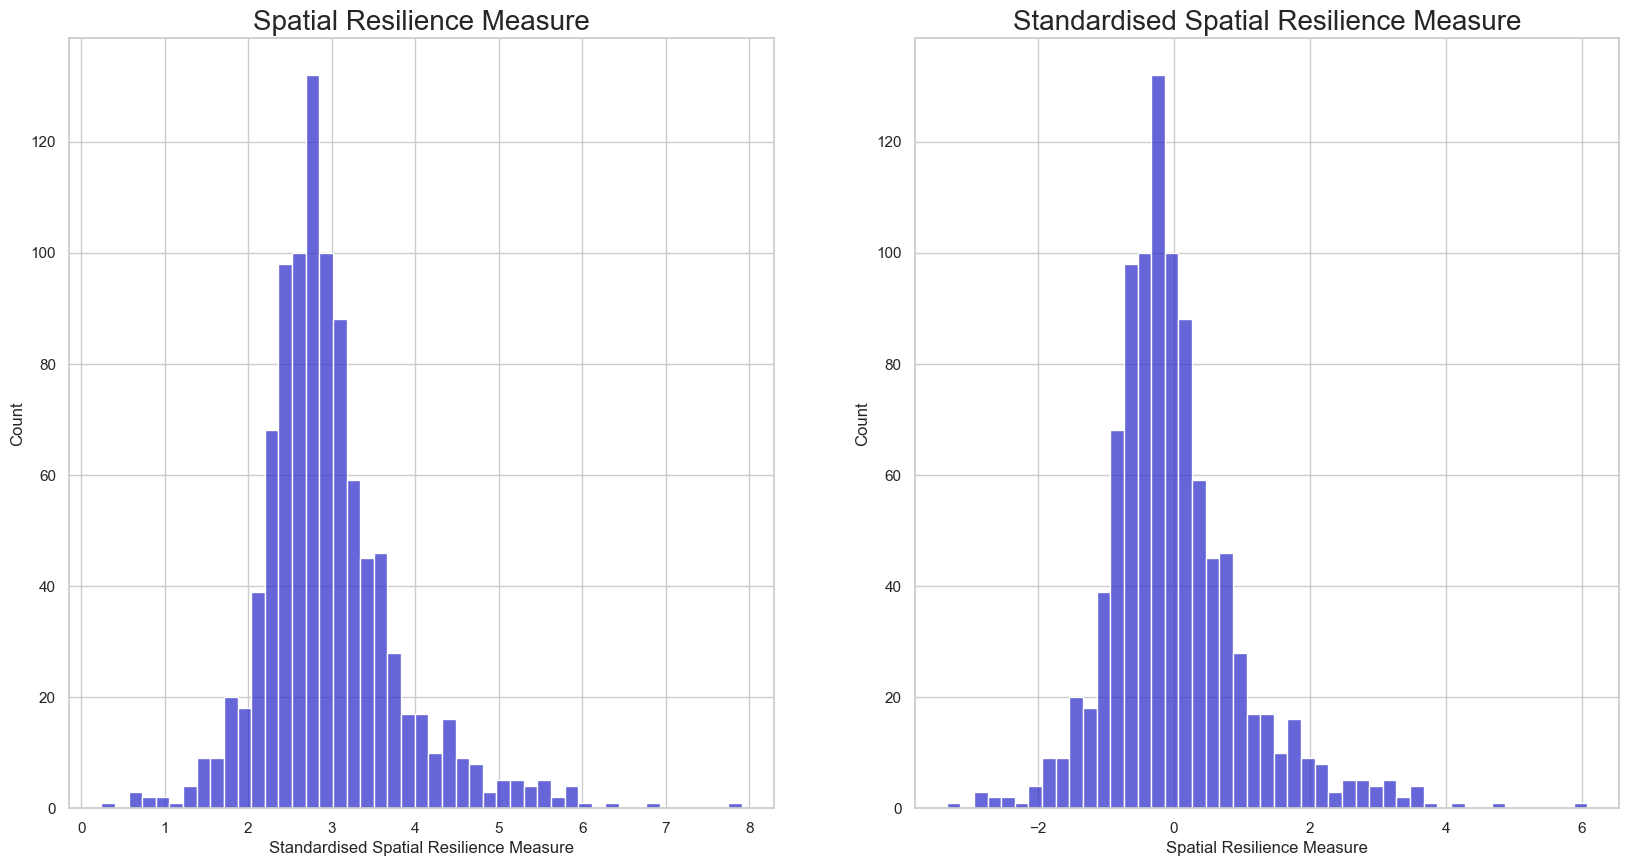

In [18]:
# Checking if standardising the SRM variable changes the distributionsignificantly. not so much.

sns.set_context('notebook')
fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=False, sharey=False)

#df = slope_msoa

p = sns.histplot(data=df, x='slope', color = '#3333CC', ax=ax[0])
q = sns.histplot(data=df, x='slope_std', color = '#3333CC', ax=ax[1])
p.set_title("Spatial Resilience Measure", fontsize = 20)
q.set_title("Standardised Spatial Resilience Measure", fontsize = 20)
q.set_xlabel("Spatial Resilience Measure", fontsize = 12)
p.set_xlabel("Standardised Spatial Resilience Measure", fontsize = 12)

plt.show()
#plt.savefig('../figures/srm_standardised.png')

In [19]:
# Name dataframe
spatial_recovery_jun = df

In [20]:
# For loop of Tukey Test to identify outliers

cols = ['cyclelength_perhect_std',
         'education_cnt_std',
         'pubtrans_cnt_std',
         'recreation_cnt_std']

outliers = pd.DataFrame()

for i in range(0, len(cols)):
    print(cols[i])
    IQR = df[cols[i]].quantile(0.75) - df[cols[i]].quantile(0.25)
    low = df[cols[i]].quantile(0.25) - 5*IQR
    high = df[cols[i]].quantile(0.75) + 5*IQR
    outlier_low = df[df[cols[i]] < low]
    outlier_high = outlier_low.append(df[df[cols[i]] > high])
    outlier_high['outlying_variable'] = cols[i]
    outliers = outliers.append(outlier_high)
    #outliers = pd.concat([outlier_low, outlier_high])
    #df_final = df.drop(outliers.index)
    #outliers_df = outliers_df.append(outliers)
    


#outliers
outliers[['msoa_name','outlying_variable', 'cyclelength_perhect_std']]
#msoa_outliers = outliers[['msoa_name']].drop_duplicates()
#msoa_outliers = msoa_outliers.reset_index()
#msoa_outliers = list(msoa_outliers['msoa_name'])
#msoa_outliers

cyclelength_perhect_std
education_cnt_std
pubtrans_cnt_std
recreation_cnt_std


,msoa_name,outlying_variable,cyclelength_perhect_std
16,Hackney 018,cyclelength_perhect_std,9.60
20,Hackney 022,cyclelength_perhect_std,11.11
227,Tower Hamlets 001,cyclelength_perhect_std,6.50
229,Tower Hamlets 003,cyclelength_perhect_std,8.09
286,Camden 028,education_cnt_std,0.38
287,City of London 001,pubtrans_cnt_std,1.29
388,Westminster 018,pubtrans_cnt_std,-0.21
928,Hillingdon 031,pubtrans_cnt_std,-0.60
414,Barking and Dagenham 021,recreation_cnt_std,0.57


In [21]:
#df.info()

In [22]:
# Save as Shape File

#spatial_recovery_jun.to_file('../output_data/spatial_recovery_junpub.shp')